In [58]:
import json
import joblib
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    MarianMTModel, MarianTokenizer
)
import glob
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [59]:
import os
import pandas as pd
import numpy as np
import torch
import re

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

In [61]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\saraujo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [62]:
import spacy
from nltk.corpus import stopwords
import string

In [63]:
# nltk.download('stopwords')

In [64]:
# !python -m spacy download en_core_web_lg

In [65]:
nlp = spacy.load("en_core_web_lg")

In [66]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stop_words = stopwords_es | stopwords_en

In [67]:
def procesar_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Procesa un DataFrame para eliminar filas con valores nulos en 'title', 'abstract' o 'decision'.
    """
    df["text"] = df["title"] + " " + df["abstract"]
    df = df.dropna(subset=["title", "abstract", "decision"])
    
    label = {"ACCEPTED": 1, "REJECTED": 0}
    df["label"] = df["decision"].map(label)
    df = df.reset_index(drop=True)
    return df    

In [68]:
# Función de limpieza y lematización
def procesar_texto(texto):
    if texto is None or texto.strip() == "":
        return ""

    # Remove numbers
    texto = re.sub(r'\d+', '', texto)

    # Remove special characters (keep only letters and spaces)
    texto = re.sub(r'\W+', ' ', texto)

    # Unicode, minúsculas, quitar puntuación
    texto = texto.strip().lower().translate(str.maketrans('', '', string.punctuation))

    # Replace multiple spaces with a single space
    texto = re.sub(r'\s+', ' ', texto)

    # Procesar con spaCy
    doc = nlp(texto)

    # Lematizar y quitar stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]

    return " ".join(tokens)

# Unir columnas y procesar
def crear_corpus(row):
    return procesar_texto(str(row))

In [69]:
class ModelLoader:
    """Clase para cargar y usar modelos guardados"""

    def __init__(self, models_dir="./models/", models_trad_dir=None, models_trans_dir=None):
        
        if models_trad_dir and (not (models_trans_dir)):
            self.models_trad_dir = models_trad_dir
            self.models_trans_dir = models_trad_dir
        elif (not (models_trad_dir)) and (models_trans_dir):
            self.models_trad_dir = models_trans_dir
            self.models_trans_dir = models_trans_dir
        elif models_trad_dir and models_trans_dir:
            self.models_trad_dir = models_trad_dir
            self.models_trans_dir = models_trans_dir
        else:
            self.models_trad_dir = models_dir
            self.models_trans_dir = models_dir
        
        print(self.models_trad_dir)
        print(self.models_trans_dir)
        self.loaded_models = {}

    def list_available_models(self):
        """Lista todos los modelos disponibles"""
        print("📋 Modelos disponibles:")

        # Modelos tradicionales
        traditional_dir = f"{self.models_trad_dir}/traditional"
        if os.path.exists(traditional_dir):
            print("\\n🤖 Modelos Tradicionales:")
            for model_folder in os.listdir(traditional_dir):
                model_path = f"{traditional_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")

        # Modelos transformer
        transformer_dir = f"{self.models_trans_dir}/transformers"
        if os.path.exists(transformer_dir):
            print("\\n🚀 Modelos Transformer:")
            for model_folder in os.listdir(transformer_dir):
                model_path = f"{transformer_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")
                        print(f"     GPU: {metadata['gpu_used']}")

    def load_traditional_model(self, model_folder):
        """Carga modelo tradicional"""
        model_dir = f"{self.models_trad_dir}/traditional/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo tradicional: {model_folder}")

        # Cargar componentes
        model_path = f"{model_dir}/model.pkl"
        vectorizer_path = f"{model_dir}/vectorizer.pkl"
        metadata_path = f"{model_dir}/metadata.json"

        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'traditional',
            'model': model,
            'vectorizer': vectorizer,
            'metadata': metadata
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, vectorizer, metadata

    def load_transformer_model(self, model_folder, device=None):
        """Carga modelo transformer"""
        model_dir = f"{self.models_trans_dir}/transformers/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo transformer: {model_folder}")

        # Detectar dispositivo
        if device is None:
            if torch.cuda.is_available():
                device = "cuda"
            elif torch.backends.mps.is_available():
                device = "mps"
            else:
                device = "cpu"

        print(f"   🔧 Usando dispositivo: {device}")

        # Cargar componentes
        metadata_path = f"{model_dir}/metadata.json"
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        model = model.to(device)
        model.eval()

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'transformer',
            'model': model,
            'tokenizer': tokenizer,
            'metadata': metadata,
            'device': device
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, tokenizer, metadata

    def predict_traditional(self, model_folder, texts):
        """Predicción con modelo tradicional"""
        print(f"🔍 Cargando modelo tradicional: {model_folder}")
        if model_folder not in self.loaded_models:
            self.load_traditional_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        vectorizer = model_data['vectorizer']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))
        print(new_list_lema[:5])  # Mostrar los primeros 5 textos procesados

        # Vectorizar textos
        X_vec = vectorizer.transform(new_list_lema)

        # Predicciones
        predictions = model.predict(X_vec)
        probabilities = None

        # Obtener probabilidades si el modelo las soporta
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X_vec)

        # Convertir a listas antes de retornar
        predictions_list = predictions.tolist() if hasattr(predictions, 'tolist') else predictions
        probabilities_list = probabilities.tolist() if probabilities is not None and hasattr(probabilities, 'tolist') else probabilities
        
        # return predictions, probabilities
        return predictions_list, probabilities_list

    def predict_transformer(self, model_folder, texts, batch_size=16):
        print(f"🔍 Cargando modelo transformer: {model_folder}")
        """Predicción con modelo transformer"""
        if model_folder not in self.loaded_models:
            self.load_transformer_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        tokenizer = model_data['tokenizer']
        device = model_data['device']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))

        predictions = []
        probabilities = []

        # Procesar en lotes
        for i in range(0, len(new_list_lema), batch_size):
            batch_texts = new_list_lema[i:i+batch_size]

            # Tokenizar
            inputs = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )

            # Mover al dispositivo
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Predicción
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

                # Probabilidades
                probs = torch.softmax(logits, dim=-1)
                probabilities.extend(probs.cpu().numpy())

                # Predicciones
                preds = torch.argmax(logits, dim=-1)
                predictions.extend(preds.cpu().numpy())

        # return np.array(predictions), np.array(probabilities)
        tmp_predictions = predictions.copy()
        for i, pred in enumerate(tmp_predictions):
            predictions[i] = int(pred)
            probabilities[i] = probabilities[i].tolist() if probabilities is not None else None
        
        return predictions, probabilities


# test

In [70]:
def read_csv_dataset(file_path):
    """Lee un dataset en formato CSV y lo convierte a DataFrame de pandas"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    df = pd.read_csv(file_path)
    df = procesar_dataframe(df)

    # Verificar que tenga las columnas esperadas
    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError("El archivo CSV debe contener las columnas 'text' y 'label'")

    return df[['text', 'label']]

In [71]:
"""Función principal - Ejemplos de uso"""
print("🎯 SDG Classifier - Inferencia con Modelos Guardados")

# Inicializar cargador de modelos
loader = ModelLoader(models_trad_dir="./models/950000", models_trans_dir="./models/200000 transformer")

# Listar modelos disponibles
loader.list_available_models()

🎯 SDG Classifier - Inferencia con Modelos Guardados
./models/950000
./models/200000 transformer
📋 Modelos disponibles:
\n🤖 Modelos Tradicionales:
   - LinearSVC_20250708_132939
     Accuracy: 0.6515
     F1-Score: 0.6504
   - Logistic_Regression_20250708_144128
     Accuracy: 0.6814
     F1-Score: 0.6809
   - Random_Forest_20250708_144028
     Accuracy: 0.8577
     F1-Score: 0.8577
   - XGBoost_20250708_144451
     Accuracy: 0.6883
     F1-Score: 0.6871
\n🚀 Modelos Transformer:
   - distilbert_20250710_0233
     Accuracy: 0.7546
     F1-Score: 0.7531
     GPU: True


In [72]:
def predict_single_texts(model_loader, model_folder, texts, model_type='auto'):
    """Predice etiquetas para textos individuales"""
    print(f"\\n🔮 Prediciendo {len(texts)} textos con modelo: {model_folder}")

    # Detectar tipo de modelo
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_trad_dir}/traditional/{model_folder}"):
                print(f"{model_loader.models_trad_dir}/traditional/{model_folder}")
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_trans_dir}/transformers/{model_folder}"):
                print(f"{model_loader.models_trans_dir}/transformers/{model_folder}")
                model_type = 'transformer'

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        print("Types", type(predictions), type(probabilities))
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        print("Types", type(predictions), type(probabilities))

    # Mostrar resultados
    print("\\n📋 Resultados:")
    for i, (text, pred) in enumerate(zip(texts, predictions)):
        prob_str = ""
        if probabilities is not None:
            max_prob = np.max(probabilities[i])
            prob_str = f" (confianza: {max_prob:.3f})"

        print(f"   {i+1}. Texto: '{text[:50]}...'")
        print(f"      Predicción: {pred}{prob_str}")

    return predictions, probabilities

In [73]:
# Ejemplo 1: Predicción de textos individuales
print("\\n" + "="*60)
print("EJEMPLO 1: Predicción de textos individuales")

sample_texts = [
    "This project focuses on clean water and sanitation for rural communities",
    "The initiative aims to reduce poverty through microfinance programs",
    "Our research addresses climate change mitigation strategies"
]

# Nota: Reemplaza con el nombre real de tu modelo
predictions, probs = predict_single_texts(loader, "Random_Forest_20250708_144028", sample_texts)
# predictions, probs = predict_single_texts(loader, "distilbert_10e_24b_0", sample_texts)


\n============================================================
EJEMPLO 1: Predicción de textos individuales
\n🔮 Prediciendo 3 textos con modelo: Random_Forest_20250708_144028
./models/950000/traditional/Random_Forest_20250708_144028
🔍 Cargando modelo tradicional: Random_Forest_20250708_144028
📥 Cargando modelo tradicional: Random_Forest_20250708_144028
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8577
🔍 Procesando 3 textos para predicción...
['project focus clean water sanitation rural community', 'initiative aim reduce poverty microfinance program', 'research address climate change mitigation strategy']
Types <class 'list'> <class 'list'>
\n📋 Resultados:
   1. Texto: 'This project focuses on clean water and sanitation...'
      Predicción: 0 (confianza: 0.510)
   2. Texto: 'The initiative aims to reduce poverty through micr...'
      Predicción: 1 (confianza: 0.840)
   3. Texto: 'Our research addresses climate change mitigation s...'
      Predicción: 1 (confianza: 0.750)


In [74]:
def evaluate_on_dataset(model_loader, model_folder, dataset_path, text_column='text',
                       label_column='label', model_type='auto'):
    """Evalúa un modelo en un dataset completo"""
    print(f"\\n📊 Evaluando modelo en dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    print(f"   📈 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.models_trad_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_trans_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")
        print(f"   🔍 Tipo de modelo detectado: {model_type}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)

    print(predictions[-5:], probabilities[-5:])
    print(true_labels[-5:], predictions[-5:])
    # Calcular métricas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\\n📊 Resultados de evaluación:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📈 F1-Score: {f1:.4f}")

    # Reporte detallado
    print(f"\\n📋 Reporte de clasificación:")
    print(classification_report(true_labels, predictions))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'probabilities': probabilities,
        'true_labels': true_labels
    }

In [75]:
# Ejemplo 2: Evaluación en dataset
print("\\n" + "="*60)
print("EJEMPLO 2: Evaluación en dataset completo")
results = evaluate_on_dataset(loader, "Random_Forest_20250708_144028", './dataset/dataset_test.csv')
# print("Para usar: ")

\n============================================================
EJEMPLO 2: Evaluación en dataset completo
\n📊 Evaluando modelo en dataset: ./dataset/dataset_test.csv
   📈 Dataset cargado: 200 muestras
   🔍 Tipo de modelo detectado: traditional
🔍 Cargando modelo tradicional: Random_Forest_20250708_144028
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within container closure closed position heat responsive actuator dispose container container mount microwave first burner fire actuate heat responsive actuator closure move open position least portion supply fire suppressant material fall toward first burner', 'integrate circuit control search space setting process integrated circuit example include wireless communication base

In [76]:
def generate_confusion_matrix(model_loader, model_folder, dataset_path, text_column='text',
                            label_column='label', model_type='auto',
                            save_plot=False, plot_filename=None, figsize=(8, 6)):
    """
    Genera y visualiza una matriz de confusión para un modelo en un dataset completo

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        save_plot: Si guardar el gráfico como archivo (default: False)
        plot_filename: Nombre del archivo para guardar (default: None)
        figsize: Tamaño de la figura (default: (8, 6))

    Returns:
        dict: Diccionario con métricas y matriz de confusión
    """

    print(f"\n🔍 Generando matriz de confusión para: {model_folder}")
    print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        try:
            df = read_csv_dataset(dataset_path)
        except:
            df = pd.read_csv(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    print(df.keys())
    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.predict_traditional}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.predict_transformer}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        predictions = [str(label) for label in predictions]
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        predictions = [str(label + 1) for label in predictions]

    # Asegurar que ambos sean del mismo tipo (soluciona el error de tipos mixtos)
    true_labels = [str(label) for label in true_labels]

    # Obtener etiquetas únicas para la matriz
    labels = sorted(unique_labels(true_labels, predictions))
    print("Labels", labels)
    if len(labels) == 3:
        # change labels 1 to 0 and 2 to 1
        label_map = {'1': '0', '2': '1'}
        predictions = [label_map.get(label) for label in predictions]

        # Obtener etiquetas únicas para la matriz
        labels = sorted(unique_labels(true_labels, predictions))
        print("New labels", labels)
        

    # Generar matriz de confusión
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Calcular métricas básicas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n📈 Métricas del modelo:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")

    # Crear visualización de la matriz de confusión
    plt.figure(figsize=figsize)

    # Usar seaborn para una visualización más bonita
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=labels,
                yticklabels=labels,
                cbar_kws={'label': 'Número de muestras'})

    plt.title(f'Matriz de Confusión - {model_folder}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Etiquetas Verdaderas', fontsize=12)
    plt.tight_layout()

    # Guardar si se solicita
    if save_plot:
        if plot_filename is None:
            plot_filename = f"./imgs/confusion_matrix_{model_folder}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"   💾 Matriz guardada como: {plot_filename}")

    plt.show()

    # Mostrar estadísticas adicionales de la matriz
    print(f"\n📋 Estadísticas de la Matriz de Confusión:")
    print(f"   📊 Forma de la matriz: {cm.shape}")
    print(f"   🏷️  Etiquetas encontradas: {labels}")
    print(f"   📈 Total de predicciones: {cm.sum()}")

    # Mostrar matriz en formato tabular
    print(f"\n📊 Matriz de Confusión (formato tabla):")
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = 'Verdadero'
    cm_df.columns.name = 'Predicho'
    print(cm_df)

    return {
        'confusion_matrix': cm,
        'labels': labels,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'confusion_matrix_df': cm_df
    }

\n============================================================
EJEMPLO 3: Matriz de Confusión y Comparación de Modelos

🔍 Generando matriz de confusión para: Random_Forest_20250708_144028
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo tradicional: Random_Forest_20250708_144028
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within container closure closed position heat responsive actuator dispose container container mount microwave first burner fire actuate heat responsive actuator closure move open position least portion supply fire suppressant material fall toward first burner', 'integrate circuit control search space setting process 

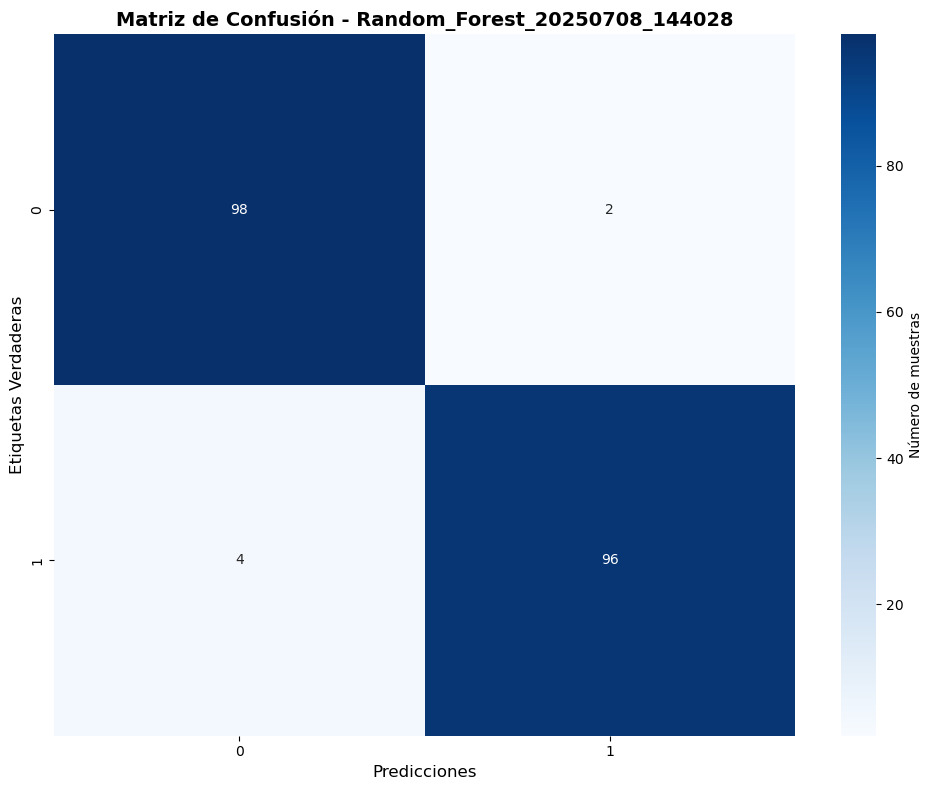


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          98   2
1           4  96
Accuracy: 0.97
Matriz como DataFrame:
Predicho    0   1
Verdadero        
0          98   2
1           4  96
✅ Función 'generate_confusion_matrix' creada exitosamente!

📝 Características principales:
   🔍 Detecta automáticamente el tipo de modelo
   📊 Genera matriz de confusión visual con seaborn
   💾 Opción para guardar el gráfico
   📈 Calcula métricas básicas (accuracy, F1)
   🏷️  Maneja automáticamente tipos mixtos de etiquetas
   📋 Muestra estadísticas detalladas


In [77]:
# Ejemplo 3: Comparar múltiples modelos
print("\\n" + "="*60)
print("EJEMPLO 3: Matriz de Confusión y Comparación de Modelos")

# Ejemplo de cómo usar la función:
results = generate_confusion_matrix(
    model_loader=loader,
    # model_folder="bert_10e_24b",
    model_folder="Random_Forest_20250708_144028",
    dataset_path='./dataset/dataset_test.csv',
    save_plot=True,
    figsize=(10, 8)
)

# Acceder a los resultados
print("Accuracy:", results['accuracy'])
print("Matriz como DataFrame:")
print(results['confusion_matrix_df'])

print("✅ Función 'generate_confusion_matrix' creada exitosamente!")
print("\n📝 Características principales:")
print("   🔍 Detecta automáticamente el tipo de modelo")
print("   📊 Genera matriz de confusión visual con seaborn")
print("   💾 Opción para guardar el gráfico")
print("   📈 Calcula métricas básicas (accuracy, F1)")
print("   🏷️  Maneja automáticamente tipos mixtos de etiquetas")
print("   📋 Muestra estadísticas detalladas")

In [ ]:
def evaluate_all_models(model_loader, dataset_path, text_column='text',
                       label_column='label', save_plots=True,
                       output_dir='./imgs', models_trad_dir="./", models_trans_dir="./"):
    """
    Evalúa todos los modelos cargados en el model_loader y genera sus matrices de confusión

    Args:
        model_loader: Instancia del cargador de modelos
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        save_plots: Si guardar los gráficos como archivos (default: False)
        output_dir: Directorio donde guardar las matrices (default: './confusion_matrices')

    Returns:
        dict: Diccionario con resultados de todos los modelos
    """

    print(f"\n🚀 Evaluando TODOS los modelos cargados")
    print(f"   📁 Dataset: {dataset_path}")

    list_models = []
    folders = glob.glob(models_trad_dir + "/traditional/*")
    for i in folders:
        list_models.append("traditional-" + i.split("\\")[-1])
    folders = glob.glob(models_trans_dir + "/transformers/*")
    for i in folders:
        list_models.append("transformers-" + i.split("\\")[-1])
    
    print(f"   📊 Modelos disponibles: {list_models}")

    if len(list_models) == 0:
        print("❌ No hay modelos cargados. Carga algunos modelos primero.")
        return {}

    # Crear directorio de salida si se van a guardar plots
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        print(f"   💾 Matrices se guardarán en: {output_dir}")

    all_results = {}
    summary_metrics = []

    print(f"\n" + "="*80)

    for type_and_model_name in list_models:
        model_type = type_and_model_name.split("-")[0]  # Extraer tipo de modelo
        model_name = type_and_model_name.split("-")[-1]  # Extraer solo el nombre del modelo
        print(f"\n🔍 Evaluando modelo: {model_name}")

        try:
            plot_filename = None
            if save_plots:
                plot_filename = f"{output_dir}/confusion_matrix_{model_name}.png"

            results = generate_confusion_matrix(
                model_loader=model_loader,
                model_folder=model_name,
                dataset_path=dataset_path,
                text_column=text_column,
                label_column=label_column,
                model_type=model_type,
                save_plot=save_plots,
                plot_filename=plot_filename,
                figsize=(8, 6)
            )

            all_results[model_name] = results

            # Guardar métricas para el resumen
            summary_metrics.append({
                'Modelo': model_name,
                'Tipo': model_type,
                'Accuracy': results['accuracy'],
                'F1-Score': results['f1_score'],
                'Num_Etiquetas': len(results['labels'])
            })

            print(f"✅ {model_name} evaluado exitosamente")

        except Exception as e:
            print(f"❌ Error evaluando {model_name}: {str(e)}")
            all_results[model_name] = {'error': str(e)}
        finally:
            print("-" * 50)

    # Crear resumen comparativo
    print(f"\n" + "="*80)
    print("📊 RESUMEN COMPARATIVO DE TODOS LOS MODELOS")
    print("="*80)

    if summary_metrics:
        summary_df = pd.DataFrame(summary_metrics)
        summary_df = summary_df.sort_values('Accuracy', ascending=False)

        print("\n🏆 Ranking por Accuracy:")
        print(summary_df.to_string(index=False, float_format='%.4f'))

        # Gráfico comparativo
        plt.figure(figsize=(12, 6))

        # Subplot 1: Accuracy
        plt.subplot(1, 2, 1)
        bars1 = plt.bar(summary_df['Modelo'], summary_df['Accuracy'],
                       color='skyblue', alpha=0.7)
        plt.title('Accuracy por Modelo', fontweight='bold')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, acc in zip(bars1, summary_df['Accuracy']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

        # Subplot 2: F1-Score
        plt.subplot(1, 2, 2)
        bars2 = plt.bar(summary_df['Modelo'], summary_df['F1-Score'],
                       color='lightcoral', alpha=0.7)
        plt.title('F1-Score por Modelo', fontweight='bold')
        plt.ylabel('F1-Score')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, f1 in zip(bars2, summary_df['F1-Score']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom')

        plt.tight_layout()

        if save_plots:
            comparison_file = f"{output_dir}/models_comparison.png"
            plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráfico comparativo guardado: {comparison_file}")

        plt.show()

        # Encontrar el mejor modelo
        best_model = summary_df.iloc[0]
        print(f"\n🥇 MEJOR MODELO:")
        print(f"   🏆 Nombre: {best_model['Modelo']}")
        print(f"   🎯 Accuracy: {best_model['Accuracy']:.4f}")
        print(f"   📈 F1-Score: {best_model['F1-Score']:.4f}")
        print(f"   🔧 Tipo: {best_model['Tipo']}")

        all_results['summary'] = {
            'summary_df': summary_df,
            'best_model': best_model.to_dict(),
            'total_models_evaluated': len(summary_metrics)
        }

    print(f"\n✅ Evaluación completa de {len(all_results)} modelos terminada")

    return all_results


def evaluate_top_k_accuracy(model_loader, model_folder, dataset_path, k=3,
                           text_column='text', label_column='label',
                           model_type='auto', verbose=True):
    """
    Evalúa si la etiqueta verdadera está entre las top-k predicciones con mayor probabilidad

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        k: Número de predicciones top a considerar (default: 3)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        verbose: Si mostrar información detallada (default: True)

    Returns:
        dict: Diccionario con métricas de top-k accuracy
    """

    if verbose:
        print(f"\n🎯 Evaluando Top-{k} Accuracy para: {model_folder}")
        print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    true_labels = df[label_column].tolist()

    if verbose:
        print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    print("Prediciendo etiquetas...")
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        predictions = [str(pred) for pred in predictions]
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        predictions = [str(pred+1) for pred in predictions]

    # Convertir etiquetas a string para consistencia
    true_labels = [str(label) for label in true_labels]

    # Obtener etiquetas únicas 
    labels = sorted(unique_labels(true_labels, predictions))
    is_three_labels = len(labels) == 3
    print("Labels", labels, is_three_labels)
    if is_three_labels:
        # change labels 1 to 0 and 2 to 1
        label_map = {'1': '0', '2': '1'}
        predictions = [label_map.get(label) for label in predictions]

        # Obtener etiquetas únicas
        labels = sorted(unique_labels(true_labels, predictions))
        print("New labels", labels, is_three_labels)

    # Calcular Top-1 accuracy (accuracy normal)
    top1_correct = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    top1_accuracy = top1_correct / len(true_labels)

    # Calcular Top-k accuracy
    topk_correct = 0
    detailed_results = []

    # Obtener las clases únicas para mapear índices
    if hasattr(model_loader.loaded_models[model_folder]['model'], 'classes_'):
        classes = model_loader.loaded_models[model_folder]['model'].classes_
    else:
        # Para modelos transformer, necesitamos obtener las clases de otra manera
        classes = sorted(list(set(true_labels + predictions)))
        classes = sorted(list(set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])))

    classes = [str(c) for c in classes]  # Asegurar que sean strings

    print(f"   🏷️ Clases detectadas: {len(classes)} clases únicas")
    # print("clases", classes)
    # print("true_labels", true_labels)
    # print(len(true_labels))
    print("predictions", predictions[:5])
    print("probabilities", probabilities[:5])

    for i, (true_label, prob_array) in enumerate(zip(true_labels, probabilities)):
        # Obtener los índices de las k probabilidades más altas
        ## Esto era cuando se retornaba un numpy array 2D ----------------------------------------------
        # if len(prob_array.shape) > 1:
        #     prob_array = prob_array[0]  # Si es 2D, tomar la primera fila
        # -----------------------------------------------------------------------------------------------

        top_k_indices = np.argsort(prob_array)[-k:][::-1]  # Índices ordenados descendente
        top_k_classes = [classes[idx] for idx in top_k_indices]
        top_k_probs = [prob_array[idx] for idx in top_k_indices]
        
        # print("top_k_classes", top_k_classes)
        # print("top_k_probs", top_k_probs)
        # print("is_three_labels", is_three_labels)
        
        if is_three_labels:
            # top_k_probs = [prob_array[idx-1] for idx in top_k_indices]
            label_map = {'1': '0', '2': '1'}
            top_k_classes = [label_map.get(label[0]) for label in top_k_classes]
            # print("--- top_k_classes", top_k_classes)
            # print("--- top_k_probs", top_k_probs)


        # Verificar si la etiqueta verdadera está en el top-k
        is_in_topk = true_label in top_k_classes
        if is_in_topk:
            topk_correct += 1

        detailed_results.append({
            'sample_idx': i,
            'true_label': true_label,
            'top_prediction': predictions[i],
            f'top_{k}_classes': top_k_classes,
            f'top_{k}_probabilities': top_k_probs,
            f'in_top_{k}': is_in_topk
        })

    topk_accuracy = topk_correct / len(true_labels)

    if verbose:
        print(f"\n📈 Resultados Top-{k} Accuracy:")
        print(f"   🎯 Top-1 Accuracy: {top1_accuracy:.4f} ({top1_correct}/{len(true_labels)})")
        print(f"   🏆 Top-{k} Accuracy: {topk_accuracy:.4f} ({topk_correct}/{len(true_labels)})")
        print(f"   📊 Mejora: +{(topk_accuracy - top1_accuracy):.4f} ({((topk_accuracy - top1_accuracy) / top1_accuracy * 100):.1f}%)")

        # Mostrar algunos ejemplos donde top-k ayudó
        helped_cases = [r for r in detailed_results if r[f'in_top_{k}'] and r['true_label'] != r['top_prediction']]
        if helped_cases and len(helped_cases) > 0:
            print(f"\n💡 Ejemplos donde Top-{k} ayudó (primeros 3):")
            for case in helped_cases[:3]:
                print(f"   📝 Muestra {case['sample_idx']}: Verdadero='{case['true_label']}', "
                      f"Predicho='{case['top_prediction']}', Top-{k}={case[f'top_{k}_classes']}")

    return {
        'top1_accuracy': top1_accuracy,
        f'top{k}_accuracy': topk_accuracy,
        'improvement': topk_accuracy - top1_accuracy,
        'improvement_percentage': ((topk_accuracy - top1_accuracy) / top1_accuracy * 100) if top1_accuracy > 0 else 0,
        'total_samples': len(true_labels),
        'top1_correct': top1_correct,
        f'top{k}_correct': topk_correct,
        'detailed_results': detailed_results,
        'k': k
    }

In [79]:
for model_name in loader.loaded_models:# loader no carga los modelos, sino es con su metodo
    print("="*60)
    print(f"🔍 Evaluando modelo: {model_name}")

🔍 Evaluando modelo: Random_Forest_20250708_144028


✅ Funciones creadas exitosamente!

📝 Funciones disponibles:

🚀 Evaluando TODOS los modelos cargados
   📁 Dataset: ./dataset/dataset_test.csv
   📊 Modelos disponibles: ['traditional-LinearSVC_20250708_132939', 'traditional-Logistic_Regression_20250708_144128', 'traditional-Random_Forest_20250708_144028', 'traditional-XGBoost_20250708_144451', 'transformers-distilbert_20250710_0233']
   💾 Matrices se guardarán en: ./imgs


🔍 Evaluando modelo: LinearSVC_20250708_132939

🔍 Generando matriz de confusión para: LinearSVC_20250708_132939
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo tradicional: LinearSVC_20250708_132939
📥 Cargando modelo tradicional: LinearSVC_20250708_132939
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.6515
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include containe

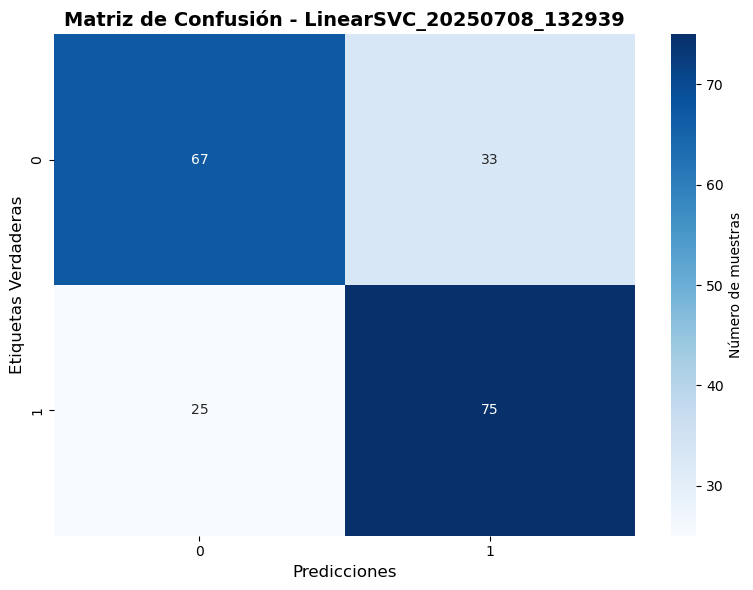


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          67  33
1          25  75
✅ LinearSVC_20250708_132939 evaluado exitosamente
--------------------------------------------------

🔍 Evaluando modelo: Logistic_Regression_20250708_144128

🔍 Generando matriz de confusión para: Logistic_Regression_20250708_144128
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo tradicional: Logistic_Regression_20250708_144128
📥 Cargando modelo tradicional: Logistic_Regression_20250708_144128
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.6814
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable 

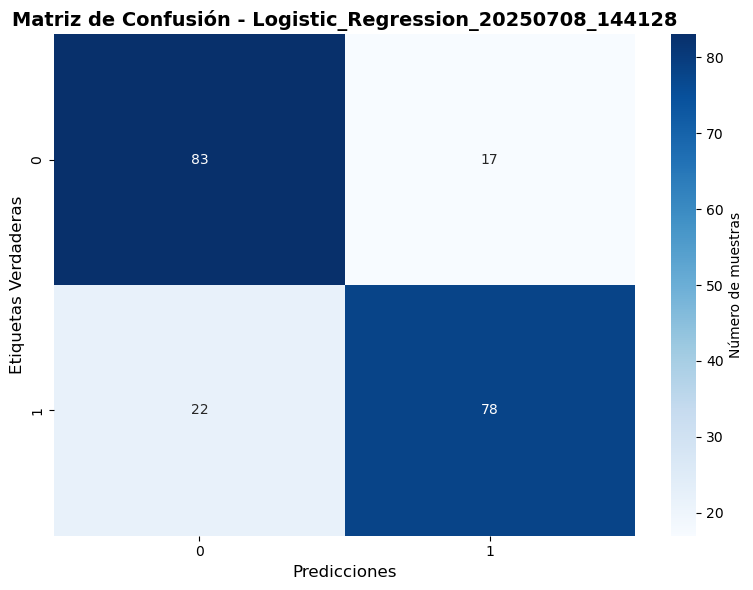


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          83  17
1          22  78
✅ Logistic_Regression_20250708_144128 evaluado exitosamente
--------------------------------------------------

🔍 Evaluando modelo: Random_Forest_20250708_144028

🔍 Generando matriz de confusión para: Random_Forest_20250708_144028
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo tradicional: Random_Forest_20250708_144028
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within containe

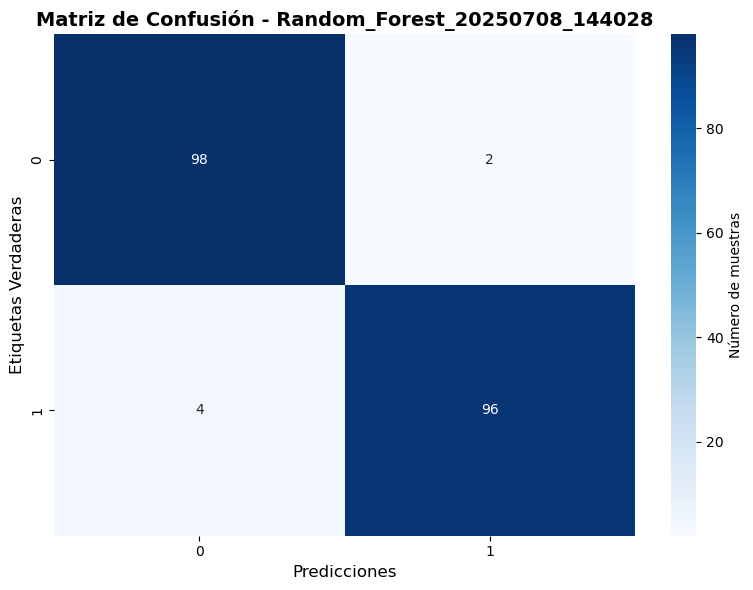


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          98   2
1           4  96
✅ Random_Forest_20250708_144028 evaluado exitosamente
--------------------------------------------------

🔍 Evaluando modelo: XGBoost_20250708_144451

🔍 Generando matriz de confusión para: XGBoost_20250708_144451
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo tradicional: XGBoost_20250708_144451
📥 Cargando modelo tradicional: XGBoost_20250708_144451
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.6883
🔍 Procesando 200 textos para predicción...
['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closu

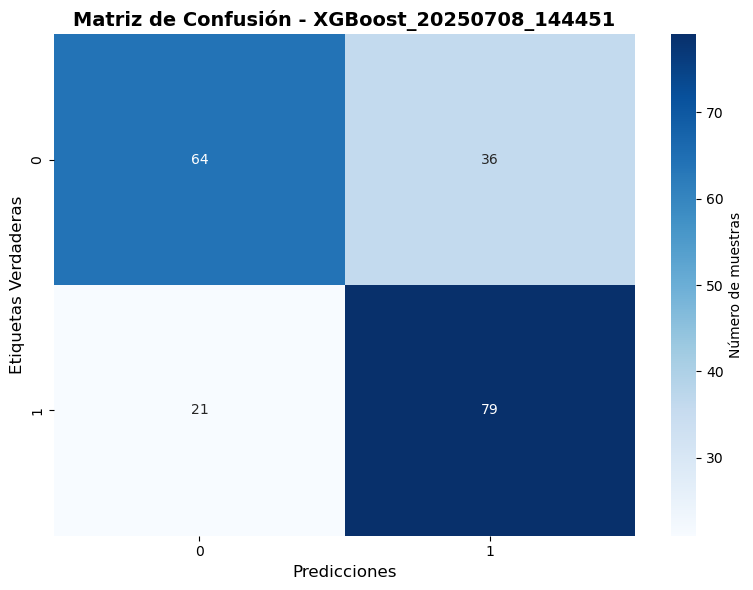


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          64  36
1          21  79
✅ XGBoost_20250708_144451 evaluado exitosamente
--------------------------------------------------

🔍 Evaluando modelo: distilbert_20250710_0233

🔍 Generando matriz de confusión para: distilbert_20250710_0233
   📁 Dataset: ./dataset/dataset_test.csv
Index(['text', 'label'], dtype='object')
   📊 Dataset cargado: 200 muestras
🔍 Cargando modelo transformer: distilbert_20250710_0233
📥 Cargando modelo transformer: distilbert_20250710_0233
   🔧 Usando dispositivo: cpu
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.7546
🔍 Procesando 200 textos para predicción...
Labels ['0', '1', '2']
New labels ['0', '1']

📈 Métricas del modelo:
   🎯 Accuracy: 0.6550
   📊 F1-Score: 0.6383
   💾 Matriz guardada como: ./imgs/confusion_matrix_distil

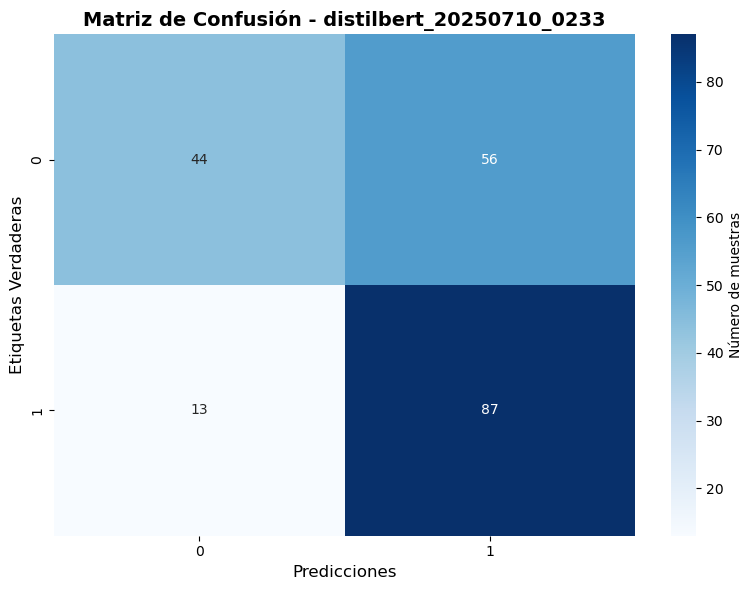


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (2, 2)
   🏷️  Etiquetas encontradas: ['0', '1']
   📈 Total de predicciones: 200

📊 Matriz de Confusión (formato tabla):
Predicho    0   1
Verdadero        
0          44  56
1          13  87
✅ distilbert_20250710_0233 evaluado exitosamente
--------------------------------------------------

📊 RESUMEN COMPARATIVO DE TODOS LOS MODELOS

🏆 Ranking por Accuracy:
                             Modelo         Tipo  Accuracy  F1-Score  Num_Etiquetas
      Random_Forest_20250708_144028  traditional    0.9700    0.9700              2
Logistic_Regression_20250708_144128  traditional    0.8050    0.8049              2
            XGBoost_20250708_144451  traditional    0.7150    0.7134              2
          LinearSVC_20250708_132939  traditional    0.7100    0.7095              2
           distilbert_20250710_0233 transformers    0.6550    0.6383              2

💾 Gráfico comparativo guardado: ./imgs/models_comparison.png


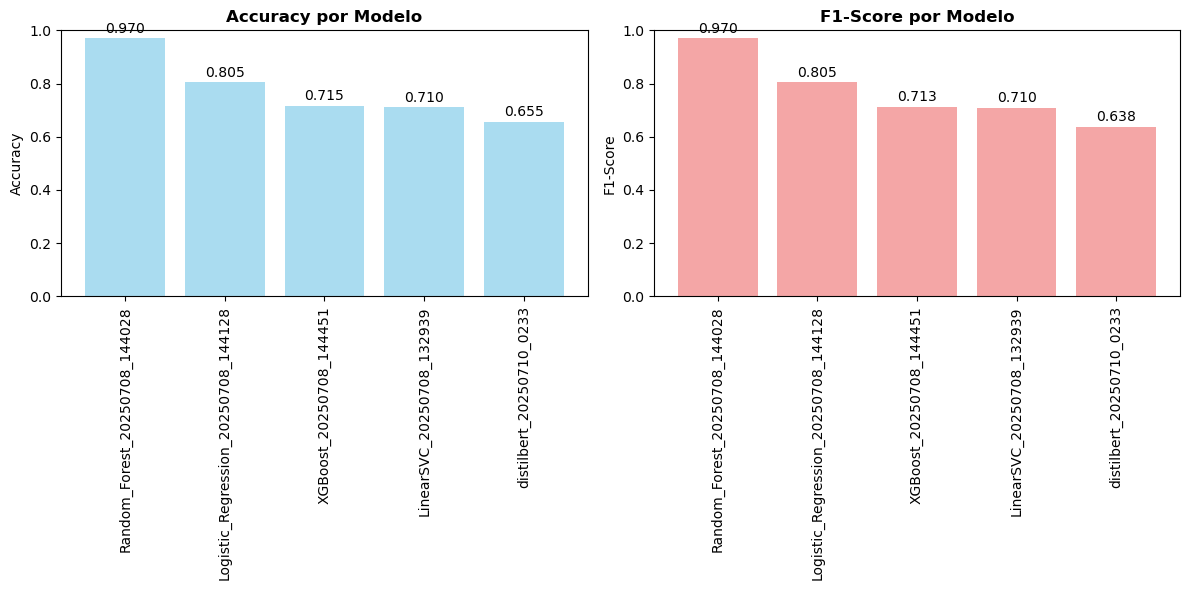


🥇 MEJOR MODELO:
   🏆 Nombre: Random_Forest_20250708_144028
   🎯 Accuracy: 0.9700
   📈 F1-Score: 0.9700
   🔧 Tipo: traditional

✅ Evaluación completa de 6 modelos terminada


In [80]:
print("✅ Funciones creadas exitosamente!")
print("\n📝 Funciones disponibles:")
result = evaluate_all_models(model_loader=loader, dataset_path='./dataset/dataset_test.csv', models_trad_dir="./models/950000", models_trans_dir="./models/200000 transformer")

In [81]:
print("   🚀  - Evalúa todos los modelos cargados")
evaluate_top_k_accuracy(
    model_loader=loader,
    # model_folder="LinearSVC_20250708_132939", # no tiene probabilidades

    # model_folder="Logistic_Regression_20250708_144128",
    # model_folder="Random_Forest_20250708_144028",
    # model_folder="XGBoost_20250708_144451",

    model_folder="distilbert_20250710_0233",
    
    dataset_path='./dataset/dataset_test.csv')

   🚀  - Evalúa todos los modelos cargados

🎯 Evaluando Top-3 Accuracy para: distilbert_20250710_0233
   📁 Dataset: ./dataset/dataset_test.csv
   📊 Dataset cargado: 200 muestras
Prediciendo etiquetas...
🔍 Cargando modelo transformer: distilbert_20250710_0233
🔍 Procesando 200 textos para predicción...
Labels ['0', '1', '2'] True
New labels ['0', '1'] True
   🏷️ Clases detectadas: 16 clases únicas
predictions ['1', '1', '0', '1', '1']
probabilities [[0.3867277204990387, 0.6132722496986389], [0.15739624202251434, 0.8426037430763245], [0.6905240416526794, 0.30947598814964294], [0.1844886988401413, 0.8155113458633423], [0.21530017256736755, 0.7846998572349548]]

📈 Resultados Top-3 Accuracy:
   🎯 Top-1 Accuracy: 0.6550 (131/200)
   🏆 Top-3 Accuracy: 1.0000 (200/200)
   📊 Mejora: +0.3450 (52.7%)

💡 Ejemplos donde Top-3 ayudó (primeros 3):
   📝 Muestra 2: Verdadero='1', Predicho='0', Top-3=['0', '1']
   📝 Muestra 9: Verdadero='1', Predicho='0', Top-3=['0', '1']
   📝 Muestra 12: Verdadero='1', P

{'top1_accuracy': 0.655,
 'top3_accuracy': 1.0,
 'improvement': 0.345,
 'improvement_percentage': 52.67175572519084,
 'total_samples': 200,
 'top1_correct': 131,
 'top3_correct': 200,
 'detailed_results': [{'sample_idx': 0,
   'true_label': '1',
   'top_prediction': '1',
   'top_3_classes': ['1', '0'],
   'top_3_probabilities': [0.6132722496986389, 0.3867277204990387],
   'in_top_3': True},
  {'sample_idx': 1,
   'true_label': '1',
   'top_prediction': '1',
   'top_3_classes': ['1', '0'],
   'top_3_probabilities': [0.8426037430763245, 0.15739624202251434],
   'in_top_3': True},
  {'sample_idx': 2,
   'true_label': '1',
   'top_prediction': '0',
   'top_3_classes': ['0', '1'],
   'top_3_probabilities': [0.6905240416526794, 0.30947598814964294],
   'in_top_3': True},
  {'sample_idx': 3,
   'true_label': '1',
   'top_prediction': '1',
   'top_3_classes': ['1', '0'],
   'top_3_probabilities': [0.8155113458633423, 0.1844886988401413],
   'in_top_3': True},
  {'sample_idx': 4,
   'true_label

In [82]:

print("\n💡 Ejemplos de uso:")
print("   ")
print("   # Evaluar top-3 accuracy de un modelo específico")
print("   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)")


💡 Ejemplos de uso:
   
   # Evaluar top-3 accuracy de un modelo específico
   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)


# load_models

In [83]:
def load_traditional_model(model_dir):
    """Carga modelo tradicional guardado"""
    model_path = f"{model_dir}/model.pkl"
    vectorizer_path = f"{model_dir}/vectorizer.pkl"
    metadata_path = f"{model_dir}/metadata.json"

    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, vectorizer, metadata

In [84]:
def load_transformer_model(model_dir):
    """Carga modelo transformer guardado"""
    metadata_path = f"{model_dir}/metadata.json"

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)

    return model, tokenizer, metadata

### Primeros pasos

In [85]:
models_dir = "./models/*"
list_dir = glob.glob(models_dir)
models_upload = {}


In [86]:
folders = glob.glob("./models/950000/traditional/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_traditional_model(i.replace("\\", "/"))

LinearSVC_20250708_132939
Logistic_Regression_20250708_144128
Random_Forest_20250708_144028
XGBoost_20250708_144451


In [87]:
folders = glob.glob("./models/200000 transformer/transformers/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_transformer_model(i.replace("\\", "/"))

distilbert_20250710_0233


In [88]:
models_upload['LinearSVC_20250708_132939']

(SGDClassifier(max_iter=100000, n_jobs=-1, random_state=42),
 TfidfVectorizer(max_features=100000, stop_words='english'),
 {'model_name': 'LinearSVC',
  'timestamp': '20250708_132939',
  'val_accuracy': 0.6493947368421052,
  'test_accuracy': 0.6514947368421052,
  'val_f1': 0.6482327707555298,
  'test_f1': 0.6503524295123465,
  'gpu_used': False,
  'model_path': './models/traditional/LinearSVC_20250708_132939/model.pkl',
  'vectorizer_path': './models/traditional/LinearSVC_20250708_132939/vectorizer.pkl'})

In [89]:
model = models_upload['Random_Forest_20250708_144028'][0]
vectorizer = models_upload['Random_Forest_20250708_144028'][1]

In [90]:
list_text = [
    # ACCEPTED
    "STOVE TOP FIRE EXTINGUISHING DEVICE An apparatus is disclosed for extinguishing a stovetop fire over a stovetop having a first burner, the apparatus including a container detachably mountable to a microwave positioned above the stove top, the container having a closure retained in a closed position on the container. A supply of fire suppressant material is retained within the container when the closure is in the closed position. A heat responsive actuator is disposed on the container. When the container is mounted to the microwave over the first burner, and the fire actuates the heat responsive actuator, the closure moves to an open position and at least a portion of the supply of fire suppressant material falls toward the first burner.",
    # ACCEPTED
    "INTEGRATED CIRCUIT THAT CONTROLS A SEARCH SPACE SETTING PROCESS An integrated circuit, for example, included in a wireless communication base station, controls a process that includes mapping a first downlink control channel to control channel element(s) (CCE(s)) in a first search space comprised of a first plurality of CCEs, the first downlink control channel including resource assignment information, which indicates a resource allocated to a terminal in a component carrier n (CCn) out of one or more component carrier(s) (CC(s)), and mapping a second downlink control channel to CCE(s) in a second search space comprised of a second plurality of CCE(s), the second downlink control channel including resource assignment information, which indicates a resource allocated to the terminal in a component carrier n+1 (CCn+1) out of the CC(s), the first plurality of CCEs and the second plurality of CCEs are consecutive. The process also includes transmitting the first and the second downlink control channels to the terminal.",
    # ACCEPTED
    "LONG CAMPAIGN LIFE STAVE COOLERS FOR CIRCULAR FURNACES WITH CONTAINMENT SHELLS Cast-iron and cast-copper stave coolers improve the campaign lives of furnaces with steel shelled vessels. Each stave cooler has a single rectangular body with one-only protruding neck on its back that includes a steel collar adaptor. All the coolant piping passes in a group through the protruding neck from two or more independent coolant circuits inside the stave body. Such stave coolers are configured to depend entirely for all their vertical mechanical support on a single hanging of the protruding neck as a through-bulkhead in a single corresponding penetration of the containment shell. Thus, a single annular welded steel-to-steel gas seal around the through-bulkhead is all that's needed inside the steel containment shell for each stave cooler. Coolant piping is laid flat in a single common layer, inside to a hot face. Cast-copper stave cooler hot faces include an abrasion resistant layer that extends campaign lives beyond ten years.",
    # ACCEPTED
    "SEMICONDUCTOR PACKAGE STRUCTURE AND METHOD FOR MANUFACTURING THE SAME A method for manufacturing a semiconductor package structure includes: (a) disposing at least one semiconductor element on a conductive structure, wherein the conductive structure includes at least one insulation layer and at least one circuit layer; (b) disposing an encapsulant on the conductive structure to cover the semiconductor element; (c) attaching a supporting structure on the conductive structure to surround the semiconductor element; and (d) disposing an upper element on the encapsulant, wherein a coefficient of thermal expansion of the upper element is in a range of variation less than or equal to about ±20% of a coefficient of thermal expansion of the circuit layer, and a bending modulus of the upper element is in a range of variation less than or equal to about ±35% of a bending modulus of the circuit layer.",
    # ACCEPTED
    "FORECASTING AND CLASSIFYING CYBER-ATTACKS USING CROSSOVER NEURAL EMBEDDINGS A first collection including a first feature vector and a Q&A feature vector is constructed. A second collection is constructed from the first collection by inserting noise in at least one of the vectors. A third collection is constructed by crossing over a feature vectors of the second collection with a corresponding feature vector of a fourth collection. The second and the fourth collections have a property similar to one another. Using a forecasting configuration, a vector of the third collection is aged to generate a changed feature vector, the changed feature vector containing feature values expected at a future time. The changed feature vector is input into a trained neural network to predict a probability of the cyber-attack occurring at the future time."
    # REJECTED
    "LIQUID EJECTING APPARATUS, DRIVE CIRCUIT, AND INTEGRATED CIRCUIT A liquid ejecting apparatus includes an ejecting unit, and first and second integrated circuits mounted respectively on front and rear surfaces of the circuit substrate. Each of the first and second integrated circuits includes a first terminal to which the first voltage is applied, and a second terminal to which the second voltage is applied. A distance between the first terminals of the first and second integrated circuits is shorter than a distance between the first terminal of the first integrated circuit and the second terminal of the second integrated circuit. A distance between the second terminal of the first integrated circuit and the second terminal of the second integrated circuit is shorter than a distance between the second terminal of the first integrated circuit and the first terminal of the second integrated circuit.",
    # REJECTED
    "CYCLOPROPANE DERIVATIVE AND DRUG CONTAINING SAME,Compounds represented by formula (I): wherein each symbol is as defined herein exhibit superior TRPA1 antagonist activity and are useful for the prophylaxis or treatment of diseases involving TRPA1 antagonist and TRPA1",
    # REJECTED
    "METHOD FOR MANAGING INDOOR BEACON-BASED COMMUNICATION A method for content distribution in an indoor space and surrounding area covered by beacon signals. The method includes setting general data of the content, setting at least one location in the indoor space, including one or a combination of active/inactive locations and other relevant information available in a system, assigning beacons that trigger the content in the indoor space, receiving by the system, from a portable device via a first communication channel, beacon information that is received from a beacon by the portable device via a second communication channel, the first communication channel being different from the second communication channel, setting a singular event or plural events which initiates the content in the indoor space, setting a condition formula for the content which must be fulfilled to qualify for the content, and setting singular or plural results of the content that are provided when the condition formula is fulfilled.",
    # REJECTED
    "Biological and Chemical Process Utilizing Chemoautotrophic Microorganisms for the Chemosynthetic Fixation of Carbon Dioxide and/or Other Inorganic Carbon Sources into Organic Compounds and the Generation of Additional Useful Products The invention described herein presents compositions and methods for a multistep biological and chemical process for the capture and conversion of carbon dioxide and/or other forms of inorganic carbon into organic chemicals including biofuels or other useful industrial, chemical, pharmaceutical, or biomass products. One or more process steps utilizes chemoautotrophic microorganisms to fix inorganic carbon into organic compounds through chemosynthesis. An additional feature described are process steps whereby electron donors used for the chemosynthetic fixation of carbon are generated by chemical or electrochemical means, or are produced from inorganic or waste sources. An additional feature described are process steps for the recovery of useful chemicals produced by the carbon dioxide capture and conversion process, both from chemosynthetic reaction steps, as well as from non-biological reaction steps.",
    # REJECTED
    "ADAPTIVE COMMUNICATION HANDLING A method can include accessing, from memory, sensor data in response to detecting an incoming communication to a given communication endpoint, the sensor data representing at least one of a condition of the given communication endpoint or a condition of an operating environment associated with the given communication endpoint. The method can also include applying a profile to the sensor data to determine whether to extend or truncate a duration that the incoming communication at the given communication endpoint. The profile may be learned based on the sensor data associated with one or more previous incoming communication being answered or not answered. The method further includes adapting the duration that the incoming communication is offered at the given communication endpoint based on the applied profile.",
]

### Preproceso
1. identificar idioma
2. traduccion de ser necesario
3. lematizacion


In [91]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
tokenizer_detected = AutoTokenizer.from_pretrained(model_ckpt)
model_detected = AutoModelForSequenceClassification.from_pretrained(model_ckpt)

In [92]:
result_list = []
inputs = tokenizer_detected(list_text, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model_detected(**inputs).logits

preds = torch.softmax(logits, dim=-1)
id2lang = model_detected.config.id2label
vals, idxs = torch.max(preds, dim=1)
result_list.extend([(id2lang[k.item()], v.item()) for k, v in zip(idxs, vals)])

result_list

[('en', 0.9861118793487549),
 ('en', 0.9665778279304504),
 ('en', 0.9873318076133728),
 ('en', 0.9760973453521729),
 ('en', 0.9825666546821594),
 ('en', 0.931645929813385),
 ('en', 0.9822390079498291),
 ('en', 0.9706765413284302),
 ('en', 0.9867146611213684)]

In [93]:
model_name = "Helsinki-NLP/opus-mt-es-en"
# model_name = "Helsinki-NLP/opus-mt-en-es"
# model_name = "Helsinki-NLP/opus-mt-tc-big-en-es"

tokenizer_tradu = MarianTokenizer.from_pretrained(model_name)
model_tradu = MarianMTModel.from_pretrained(model_name)

In [94]:
def get_translation(text):
  translated = model_tradu.generate(**tokenizer_tradu(text, return_tensors="pt", padding=True))
  return tokenizer_tradu.decode(translated[0], skip_special_tokens=True)

In [95]:
list_new_text = []

for i in range(len(result_list)):
    lang = result_list[i][0]
    if lang == "es":
        print(f"Translating text {i} from Spanish to English")
        resp = get_translation(list_text[i])
        print(resp)
        list_new_text.append(resp)
    else:
        list_new_text.append(list_text[i])

lematizacion de la lista

In [96]:
new_list_lema = []

if len(list_new_text) == 0:
    list_new_text = list_text

for text in list_new_text:
    new_list_lema.append(crear_corpus(text))

### Prueba

In [97]:
models_upload.keys()

dict_keys(['LinearSVC_20250708_132939', 'Logistic_Regression_20250708_144128', 'Random_Forest_20250708_144028', 'XGBoost_20250708_144451', 'distilbert_20250710_0233'])

##### Traditional

In [98]:
# key_model = "LinearSVC_20250708_132939"
key_model = "Random_Forest_20250708_144028"
list_text = new_list_lema
model = models_upload[key_model][0]
vectorizer = models_upload[key_model][1]

In [99]:
# Vectorizar textos
X_vec = vectorizer.transform(list_text)

# Predicciones
predictions = model.predict(X_vec)
probabilities = None

# Obtener probabilidades si el modelo las soporta
if hasattr(model, 'predict_proba'):
    probabilities = model.predict_proba(X_vec)

In [100]:
probabilities

array([[0.15, 0.85],
       [0.24, 0.76],
       [0.39, 0.61],
       [0.13, 0.87],
       [0.36, 0.64],
       [0.65, 0.35],
       [0.63, 0.37],
       [0.91, 0.09],
       [0.95, 0.05]])

In [101]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred}{prob_str}")

   1. Texto: 'stove top fire extinguishing device apparatus disc...'
      Predicción: 1 (confianza: 0.850)
   2. Texto: 'integrate circuit control search space setting pro...'
      Predicción: 1 (confianza: 0.760)
   3. Texto: 'long campaign life stave cooler circular furnace c...'
      Predicción: 1 (confianza: 0.610)
   4. Texto: 'semiconductor package structure method manufacture...'
      Predicción: 1 (confianza: 0.870)
   5. Texto: 'forecast classify cyber attack use crossover neura...'
      Predicción: 1 (confianza: 0.640)
   6. Texto: 'cyclopropane derivative drug contain compound repr...'
      Predicción: 0 (confianza: 0.650)
   7. Texto: 'method manage indoor beacon base communication met...'
      Predicción: 0 (confianza: 0.630)
   8. Texto: 'biological chemical process utilize chemoautotroph...'
      Predicción: 0 (confianza: 0.910)
   9. Texto: 'adaptive communication handle method include acces...'
      Predicción: 0 (confianza: 0.950)


In [102]:
# predictions = ya es la clase predicha
# probabilities = es la probabilidad de cada clase

In [103]:
# predictions[2], probabilities[2]

In [104]:
predictions

array([1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

In [105]:
for index in range(len(list_text)):
    print("Text:", list_text[index])
    res_probabilities = list(probabilities[index])
    res_probabilities_sort = list(probabilities[index])
    res_probabilities_sort.sort(reverse=True)
    for i in range(2): # solo son dos top
        print(f"{res_probabilities.index(res_probabilities_sort[i])} con confianza: {res_probabilities_sort[i]:.3f})")

Text: stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within container closure closed position heat responsive actuator dispose container container mount microwave first burner fire actuate heat responsive actuator closure move open position least portion supply fire suppressant material fall toward first burner
1 con confianza: 0.850)
0 con confianza: 0.150)
Text: integrate circuit control search space setting process integrated circuit example include wireless communication base station control process include mapping first downlink control channel control channel element cce first search space comprise first plurality cce first downlink control channel include resource assignment information indicate resource allocate terminal component carrier n ccn one component

##### Transformers

In [106]:
list_text

['stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within container closure closed position heat responsive actuator dispose container container mount microwave first burner fire actuate heat responsive actuator closure move open position least portion supply fire suppressant material fall toward first burner',
 'integrate circuit control search space setting process integrated circuit example include wireless communication base station control process include mapping first downlink control channel control channel element cce first search space comprise first plurality cce first downlink control channel include resource assignment information indicate resource allocate terminal component carrier n ccn one component carrier cc mapping second downlink control channel cc

In [107]:
models_upload.keys()

dict_keys(['LinearSVC_20250708_132939', 'Logistic_Regression_20250708_144128', 'Random_Forest_20250708_144028', 'XGBoost_20250708_144451', 'distilbert_20250710_0233'])

In [108]:
key_model = "distilbert_20250710_0233"
list_text = new_list_lema
model = models_upload[key_model][0]
tokenizer = models_upload[key_model][1]
device = "cpu" # models_upload[key_model][2]['device']

In [109]:
predictions = []
probabilities = []

# Tokenizar
inputs = tokenizer(
    list_text,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Mover al dispositivo
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

    # Probabilidades
    probs = torch.softmax(logits, dim=-1)
    probabilities.extend(probs.cpu().numpy())

    # Predicciones
    preds = torch.argmax(logits, dim=-1)
    predictions.extend(preds.cpu().numpy())

In [110]:
# inputs.keys()
# inputs['input_ids']
# inputs['attention_mask']

In [111]:
# predictions = es el indice de la clase predicha
# probabilities = es la probabilidad de cada clase

In [112]:
# predictions, probabilities

In [113]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred}{prob_str}")

   1. Texto: 'stove top fire extinguishing device apparatus disc...'
      Predicción: 1 (confianza: 0.613)
   2. Texto: 'integrate circuit control search space setting pro...'
      Predicción: 1 (confianza: 0.843)
   3. Texto: 'long campaign life stave cooler circular furnace c...'
      Predicción: 0 (confianza: 0.691)
   4. Texto: 'semiconductor package structure method manufacture...'
      Predicción: 1 (confianza: 0.816)
   5. Texto: 'forecast classify cyber attack use crossover neura...'
      Predicción: 1 (confianza: 0.823)
   6. Texto: 'cyclopropane derivative drug contain compound repr...'
      Predicción: 1 (confianza: 0.590)
   7. Texto: 'method manage indoor beacon base communication met...'
      Predicción: 0 (confianza: 0.728)
   8. Texto: 'biological chemical process utilize chemoautotroph...'
      Predicción: 1 (confianza: 0.504)
   9. Texto: 'adaptive communication handle method include acces...'
      Predicción: 1 (confianza: 0.645)


In [114]:
for index in range(len(list_text)):
    print("Text:", list_text[index])
    res_probabilities = list(probabilities[index])
    res_probabilities_sort = list(probabilities[index])
    res_probabilities_sort.sort(reverse=True)
    for i in range(2):
        print(f"{res_probabilities.index(res_probabilities_sort[i])} con confianza: {res_probabilities_sort[i]:.3f})")

# 12, 16, 4, 16, 6, 3, 4, 16, 5, 6, 2, 14

Text: stove top fire extinguishing device apparatus disclose extinguish stovetop fire stovetop first burner apparatus include container detachably mountable microwave position stove top container closure retain closed position container supply fire suppressant material retain within container closure closed position heat responsive actuator dispose container container mount microwave first burner fire actuate heat responsive actuator closure move open position least portion supply fire suppressant material fall toward first burner
1 con confianza: 0.613)
0 con confianza: 0.387)
Text: integrate circuit control search space setting process integrated circuit example include wireless communication base station control process include mapping first downlink control channel control channel element cce first search space comprise first plurality cce first downlink control channel include resource assignment information indicate resource allocate terminal component carrier n ccn one component